# Predicting Player Value based on basic stats

## Usual Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read the Data

In [2]:
player_dataframe = pd.read_csv("playerdata.csv")
player_dataframe = player_dataframe[['Name', 'Position', 'Market Value', 'Age', 'Goals', 'Assists']]

player_dataframe.head(9)

,Name,Position,Market Value,Age,Goals,Assists
0,Erling Haaland,Centre-Forward,200000000,24,14,0
1,Vinicius Junior,Left Winger,200000000,24,5,7
2,Jude Bellingham,Attacking Midfield,180000000,21,1,2
3,Kylian Mbappé,Centre-Forward,180000000,25,8,1
4,Lamine Yamal,Right Winger,150000000,17,5,6
5,Phil Foden,Right Winger,150000000,24,1,2
6,Bukayo Saka,Right Winger,140000000,23,3,7
7,Florian Wirtz,Attacking Midfield,130000000,21,7,3
8,Jamal Musiala,Attacking Midfield,130000000,21,4,6


In [3]:
attacking_positions = ['Right Winger', 'Left Winger', 'Centre-Forward']

# Filter the DataFrame
df = player_dataframe[player_dataframe['Position'].isin(attacking_positions)].copy()

# To reset the indexes
df.reset_index(drop=True, inplace=True)

df.head(9)

,Name,Position,Market Value,Age,Goals,Assists
0,Erling Haaland,Centre-Forward,200000000,24,14,0
1,Vinicius Junior,Left Winger,200000000,24,5,7
2,Kylian Mbappé,Centre-Forward,180000000,25,8,1
3,Lamine Yamal,Right Winger,150000000,17,5,6
4,Phil Foden,Right Winger,150000000,24,1,2
5,Bukayo Saka,Right Winger,140000000,23,3,7
6,Rodrygo,Right Winger,110000000,23,3,2
7,Lautaro Martínez,Centre-Forward,110000000,27,3,3
8,Harry Kane,Centre-Forward,100000000,31,15,6


In [4]:
df['Position'] = df['Position'].str.replace('Centre-Forward', 'Centre Forward')

df.head(9)

,Name,Position,Market Value,Age,Goals,Assists
0,Erling Haaland,Centre Forward,200000000,24,14,0
1,Vinicius Junior,Left Winger,200000000,24,5,7
2,Kylian Mbappé,Centre Forward,180000000,25,8,1
3,Lamine Yamal,Right Winger,150000000,17,5,6
4,Phil Foden,Right Winger,150000000,24,1,2
5,Bukayo Saka,Right Winger,140000000,23,3,7
6,Rodrygo,Right Winger,110000000,23,3,2
7,Lautaro Martínez,Centre Forward,110000000,27,3,3
8,Harry Kane,Centre Forward,100000000,31,15,6



### Plotting the Data

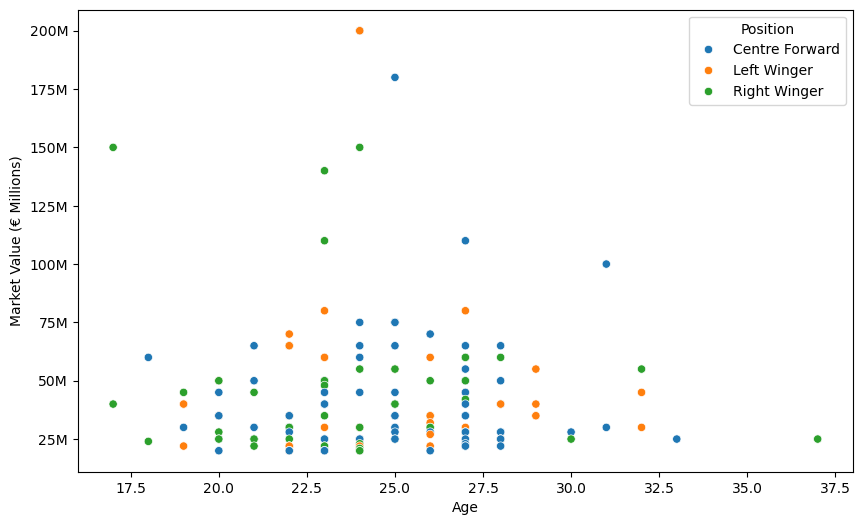

In [5]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=df, x='Age', y='Market Value', hue='Position')

# Format y-axis labels in millions
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f'{x/1_000_000:.0f}M')
)
plt.ylabel('Market Value (€ Millions)')
plt.show()

### Creating a HotEncoder for Player Positions

`Position` column contains text values ('Left Winger', 'Right Winger', 'Centre Forward').
Linear regression can't work directly with text and it needs numbers. 

One-hot encoding converts these categories into binary (0/1) columns.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# One-hot encode the categorical 'Position' column
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Position'])
    ],
    remainder='passthrough'
)

### Prepping the Data

Convert Position into machine-readable stuff

In [7]:
df_x = df[['Position', 'Age', 'Goals', 'Assists']]
df_y = df['Market Value']

processed_x = preprocessor.fit_transform(df_x)

feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['Position'])
remaining_features = ['Age', 'Goals', 'Assists']
all_features = list(feature_names) + remaining_features

### Data Splitting (70/30) (train/test)

In [8]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    processed_x, df_y, test_size=0.2, random_state=42
)

### Actual Work

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regression_model = LinearRegression()
regression_model.fit(train_x, train_y)

print("Regression Success!")

coefficients = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': regression_model.coef_
})
print("\nFeature Coefficients:")
print(coefficients)
print(f"\nIntercept: {regression_model.intercept_:.2f}")

Regression Success!

Feature Coefficients:
                   Feature   Coefficient
0  Position_Centre Forward -3.560901e+06
1     Position_Left Winger  2.116016e+06
2    Position_Right Winger  1.444885e+06
3                      Age -8.980150e+05
4                    Goals  2.729762e+06
5                  Assists  4.164630e+06

Intercept: 51450462.72


### Making Predictions and Measuring Metrics

In [10]:
# Make predictions
test_y_prediction = regression_model.predict(test_x)

# Calculate metrics
mse = mean_squared_error(test_y, test_y_prediction)
rmse = np.sqrt(mse)
r2 = round(r2_score(test_y, test_y_prediction), 2)

print(f"Root Mean Squared Error: {rmse:.2f}")
print("R2-score: ", r2)

Root Mean Squared Error: 16171657.67
R2-score:  0.16


In [11]:
new_player = pd.DataFrame({
    'Position': ['Left Winger'],
    'Age': [20],
    'Goals': [0],
    'Assists': [0]
})

new_player_processed = preprocessor.transform(new_player)

# Predict market value
predicted_value = regression_model.predict(new_player_processed)
print(f"\nPredicted Market Value: {predicted_value[0]:.2f} million")

## TODO: if predicted value is negative: Print worthless


Predicted Market Value: 35606178.78 million
